# MTA EDA

The following notebook investigates the MTA data form May 12, 2018. 

Let's start my importing libraries to enable us to make pretty plots and read in the data set. 

In [190]:

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (5, 3)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 10
rcParams['patch.edgecolor'] = 'none'

In [191]:
df = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180512.txt')

In [192]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,00:00:00,REGULAR,6607801,2239047
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,04:00:00,REGULAR,6607821,2239051
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,08:00:00,REGULAR,6607830,2239083
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,12:00:00,REGULAR,6607921,2239160
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/05/2018,16:00:00,REGULAR,6608151,2239219


In [193]:
#remove white spaces and make everything lower case for columns names
df.columns = [col.lower().strip() for col in df.columns]

Notice that the entries and exits columns are accumulations rather than net differences between two successive timestamps. In order to fix this, we can group by each individual unit and use the .diff() method.

In [194]:
df[['entries', 'exits']] = df.groupby('unit').diff()

In [195]:
df.entries.describe()

count    1.961910e+05
mean    -2.396408e+04
std      4.073140e+07
min     -2.117457e+09
25%      9.000000e+00
50%      7.900000e+01
75%      2.650000e+02
max      2.122190e+09
Name: entries, dtype: float64

In [196]:
df.exits.describe()

count    1.961910e+05
mean    -4.918669e+04
std      3.664965e+07
min     -2.040374e+09
25%      8.000000e+00
50%      5.500000e+01
75%      1.790000e+02
max      2.035768e+09
Name: exits, dtype: float64

Looking into the describe() outputs for both of our newly formed columns is alarming.  We have both maximium and minimum values that are completely infeasible.  In order to fix this problem, I am setting all of the negative values to 0 and all of values larger than its 98.7th percentile. The exact threshold was somewhat arbitrary, but I messed with the threshold until it gave me belieavable maximum values.  

Furthermore, since we care more about trends in the data, omitting < 2% of the data should have no effect on trends we see. 

In [199]:
df.entries[df.entries < 0] = 0
df.entries[df.entries > df.entries.quantile(0.987)] = 0

In [200]:
df.exits[df.exits < 0] = 0
df.exits[df.exits > df.exits.quantile(0.987)] = 0

In [202]:
df.entries.describe()

count    196191.000000
mean        177.294524
std         247.515518
min           0.000000
25%           7.000000
50%          73.000000
75%         250.000000
max        1635.000000
Name: entries, dtype: float64

In [201]:
df.exits.describe()

count    196191.000000
mean        133.351224
std         207.105096
min           0.000000
25%           6.000000
50%          51.000000
75%         168.000000
max        1595.000000
Name: exits, dtype: float64

That looks much better now- the maximum suggests an incoming rate of 400 people per hour, which is feasible. 

## Histogram of Entries and Exits by Station

In [208]:
grouped_by_station = df.groupby('station').sum()

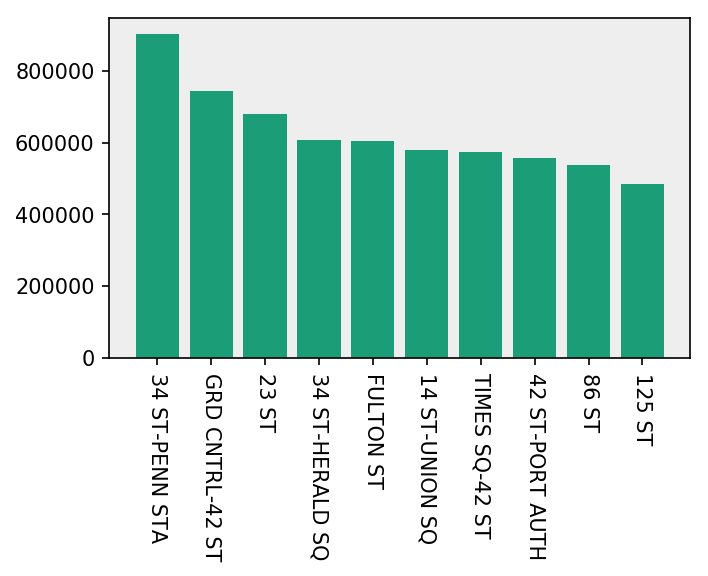

In [210]:
sorted_station_entries = grouped_by_station.sort_values(['entries'],\
                                                ascending = False)

plt.bar(range(len(sorted_station_entries.index[0:10])), \
        sorted_station_entries.entries[0:10], \
        tick_label = sorted_station_entries.index[0:10])
plt.xticks(rotation = 270)
plt.show()

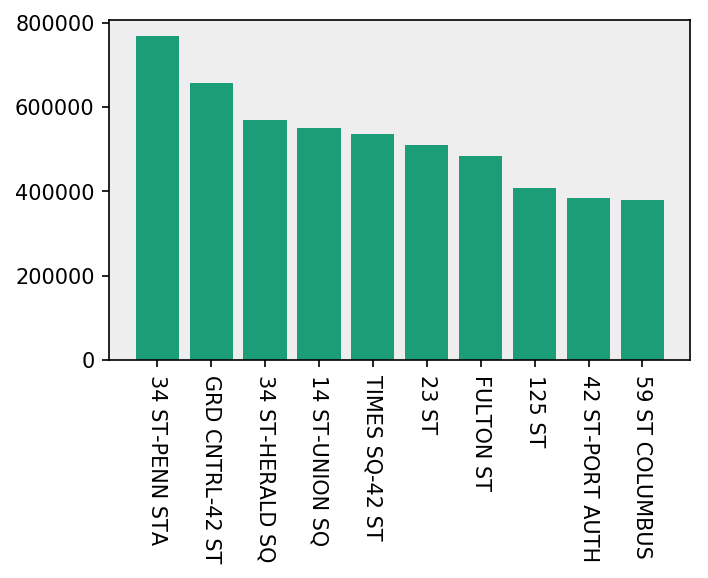

In [206]:
sorted_station_exits = grouped_by_station.sort_values(['exits'],\
                                                ascending = False)

plt.bar(range(len(sorted_station_exits.index[0:10])), \
        sorted_station_exits.exits[0:10], \
        tick_label = sorted_station_exits.index[0:10])
plt.xticks(rotation = 270)
plt.show()